# Self-Supervised Representation Learning

##  (a) Fine-tuning the BERT model on IMDB dataset for Sentiment classification

In [1]:
import sys
import gc
import re
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import torch
from torch.utils.data import DataLoader
import torchinfo

import transformers
from transformers import pipeline
from transformers import AutoModel, AutoTokenizer
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig
from transformers import AdamW, get_linear_schedule_with_warmup
transformers.logging.set_verbosity('CRITICAL')

from tqdm import tqdm
tqdm.pandas()

from bs4 import BeautifulSoup
import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt



In [2]:
imdb_df = pd.read_csv('IMDB_Dataset.csv')

# Remove rows with missing values from the data
imdb_df = imdb_df.dropna()

imdb_df.sample(5, random_state=0)

,review,sentiment
11841,John Cassavetes is on the run from the law. He...,positive
19602,It's not just that the movie is lame. It's mor...,negative
45519,"Well, if it weren't for Ethel Waters and a 7-y...",negative
25747,I find Alan Jacobs review very accurate concer...,positive
42642,This movie is simply awesome. It is so hilario...,positive


In [3]:
# Encode the sentiment labels by assigning an integer value for each unique category value

idx_to_sentiment = {k: v for k, v in enumerate(imdb_df['sentiment'].unique())}
sentiment_to_idx = {v: k for k, v in idx_to_sentiment.items()}
print(f'Encoded sentiment values: {sentiment_to_idx}')

Encoded sentiment values: {'positive': 0, 'negative': 1}


In [4]:
imdb_df['label'] = imdb_df['sentiment'].apply(lambda x: sentiment_to_idx[x])
imdb_df['label'] = imdb_df['label'].apply(lambda x: torch.tensor(x))
imdb_df.sample(5, random_state=0)

,review,sentiment,label
11841,John Cassavetes is on the run from the law. He...,positive,tensor(0)
19602,It's not just that the movie is lame. It's mor...,negative,tensor(1)
45519,"Well, if it weren't for Ethel Waters and a 7-y...",negative,tensor(1)
25747,I find Alan Jacobs review very accurate concer...,positive,tensor(0)
42642,This movie is simply awesome. It is so hilario...,positive,tensor(0)


In [5]:
#  Define the function for text cleanup(preprocess)

def preprocess(text: str):
    """
    Cleans(preprocesses) the reviews text before tokenizing it
    ----------
    text (str): raw review text data
    """
    emojis = r'[\U0001F600-\U0001F64F'\
           + r'\U0001F300-\U0001F5FF'\
           + r'\U0001F680-\U0001F6FF'\
           + r'\U0001F1E0-\U0001F1FF'\
           + r'\U00002702-\U000027B0'\
           + r'\U000024C2-\U0001F251]+'
    non_ASCII = r'[^\x00-\x7F]+'
    mentions = r'@[A-Za-z0-9_-]+'
    urls = r'https?://[A-Za-z0-9./]+'
    punctuation = r'[.,#!$%\^&\*;:{}=\-_`~()]'
    punctuation_space = r'[\/\\]'
    whitespace = r'\s+'
    
    # The text sometimes contains html elements, clean it up 
    soup = BeautifulSoup(text, 'lxml')
    text = soup.get_text()

    # Replace all non-ASCII characters with space
    text = re.sub(non_ASCII, ' ', text)
    # Replace all emojis with space
    text = re.sub(emojis, ' ', text)
    # Remove Twitter mentions with usernames
    text = re.sub(mentions, '', text)
    # Remove all urls
    text = re.sub(urls, '', text)
    # Remove the punctuation marks
    text = re.sub(punctuation, '', text)
    # Removing some punctuation marks will fuse the words,
    # replace them with space instead
    text = re.sub(punctuation_space, ' ', text)
    # Remove multiple spaces, tabs and other whitespaces with one space
    text = re.sub(whitespace, ' ', text)

    # Convert text to lower case
    text = text.lower()
    return text

In [6]:
# create new column after preprocess
imdb_df['review_preprocessed'] = imdb_df['review'].progress_apply(preprocess)
imdb_df.sample(5, random_state=0)

100%|████████████████████████████████████████████████████████████████████████████| 50000/50000 [01:02<00:00, 794.62it/s]


,review,sentiment,label,review_preprocessed
11841,John Cassavetes is on the run from the law. He...,positive,tensor(0),john cassavetes is on the run from the law he ...
19602,It's not just that the movie is lame. It's mor...,negative,tensor(1),it's not just that the movie is lame it's more...
45519,"Well, if it weren't for Ethel Waters and a 7-y...",negative,tensor(1),well if it weren't for ethel waters and a 7yea...
25747,I find Alan Jacobs review very accurate concer...,positive,tensor(0),i find alan jacobs review very accurate concer...
42642,This movie is simply awesome. It is so hilario...,positive,tensor(0),this movie is simply awesome it is so hilariou...


In [7]:
# Load the BERT tokenizer to convert our text into tokens that correspond to BERT vocabulary

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [8]:
def get_tokens(text: str):
    """
    Tokenizes the cleaned(preprocessed) up text using the defined BERT tokenizer
    ----------
    text (str): cleaned review text data
    """
    encoded_dict = tokenizer.encode_plus(text,
                                         add_special_tokens=True,
                                         truncation=True,
                                         max_length=256,
                                         padding='max_length',
                                         return_attention_mask=True,
                                         return_tensors='pt')
    input_ids = encoded_dict['input_ids'].squeeze(0)
    attention_mask = encoded_dict['attention_mask'].squeeze(0)
    return input_ids, attention_mask

In [9]:
# Apply the function to our data and save the tokenized sentences and attention masks in Pandas dataframe
imdb_df['input_ids'], imdb_df['attention_mask'] = zip(*imdb_df['review_preprocessed'].progress_apply(get_tokens))
imdb_df.sample(5, random_state=0)

100%|█████████████████████████████████████████████████████████████████████████████| 50000/50000 [10:29<00:00, 79.42it/s]


,review,sentiment,label,review_preprocessed,input_ids,attention_mask
11841,John Cassavetes is on the run from the law. He...,positive,tensor(0),john cassavetes is on the run from the law he ...,"[tensor(101), tensor(2198), tensor(16220), ten...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
19602,It's not just that the movie is lame. It's mor...,negative,tensor(1),it's not just that the movie is lame it's more...,"[tensor(101), tensor(2009), tensor(1005), tens...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
45519,"Well, if it weren't for Ethel Waters and a 7-y...",negative,tensor(1),well if it weren't for ethel waters and a 7yea...,"[tensor(101), tensor(2092), tensor(2065), tens...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
25747,I find Alan Jacobs review very accurate concer...,positive,tensor(0),i find alan jacobs review very accurate concer...,"[tensor(101), tensor(1045), tensor(2424), tens...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
42642,This movie is simply awesome. It is so hilario...,positive,tensor(0),this movie is simply awesome it is so hilariou...,"[tensor(101), tensor(2023), tensor(3185), tens...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."


In [10]:
# Create a custom PyTorch Dataset class for our data
class TextDataset(torch.utils.data.Dataset):
    """
    Class to create PyTorch dataset for the sentiment analysis task
    """

    def __init__(self, data_df: pd.DataFrame):
        """
        Create the PyTorch dataset for the sentiment analysis task
        Parameters
        ----------
        data_df (pd.DataFrame): prepared data in Pandas DataFrame format
        """

        self.data_df = data_df

    def __len__(self):
        """
        Returns
        ----------
        data_len (int): dataset length
        """
        data_len = self.data_df.shape[0]
        return data_len

    def __getitem__(self, idx: int):
        """
        Gets tokenized text, attention masks and labels by id
        
        Parameters
        ----------
        idx (int): data item id
        
        Returns
        ----------
        input_ids (torch.Tensor): tokenized text
        attention_mask (torch.Tensor): attention mask
        label (torch.Tensor): sentiment label
        """
        input_ids = self.data_df.iloc[idx]['input_ids']
        attention_mask = self.data_df.iloc[idx]['attention_mask']
        label = self.data_df.iloc[idx]['label']
        return input_ids, attention_mask, label

In [11]:

# ensure equal number of both labels in train and val splits
train_split, test_split = train_test_split(imdb_df, test_size=0.2, random_state=0, stratify=imdb_df['sentiment'])
val_split, test_split = train_test_split(test_split, test_size=0.5, random_state=0, stratify=test_split['sentiment'])

# train_val_split, test_split = train_test_split(imdb_df, test_size=0.8, random_state=0, stratify=imdb_df['sentiment'])
# train_split, val_split = train_test_split(train_val_split, test_size=0.5, random_state=0, stratify=train_val_split['sentiment'])

In [12]:
train_split.head()

,review,sentiment,label,review_preprocessed,input_ids,attention_mask
38414,The notion of marital fidelity portrayed in th...,positive,tensor(0),the notion of marital fidelity portrayed in th...,"[tensor(101), tensor(1996), tensor(9366), tens...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
24010,What a good film! Made Men is a great action m...,positive,tensor(0),what a good film made men is a great action mo...,"[tensor(101), tensor(2054), tensor(1037), tens...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
29873,"Joe Don Baker. He was great in ""Walking Tall"" ...",negative,tensor(1),"joe don baker he was great in ""walking tall"" a...","[tensor(101), tensor(3533), tensor(2123), tens...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
2868,Monarch Cove was one of the best Friday night'...,positive,tensor(0),monarch cove was one of the best friday night'...,"[tensor(101), tensor(11590), tensor(11821), te...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
15107,This film is so unbelievable; - the whole prem...,negative,tensor(1),this film is so unbelievable the whole premise...,"[tensor(101), tensor(2023), tensor(2143), tens...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."


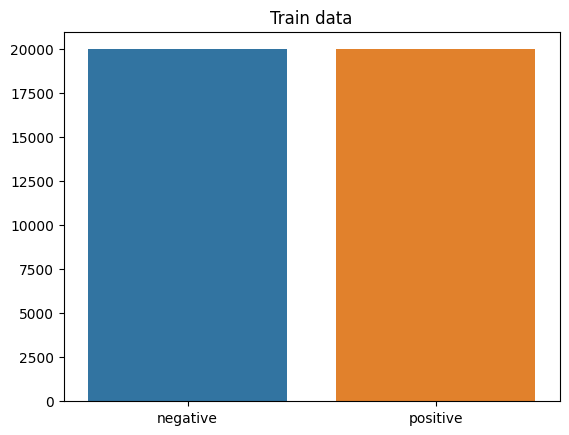

In [13]:


# assume train_split is the dataframe containing the training set

dd = train_split['sentiment'].value_counts()
sns.barplot(x=np.array(['negative','positive']),y=dd.values)
plt.title("Train data")
plt.show()

In [38]:
# dataloaders
train_dataset = TextDataset(train_split)
train_loader = DataLoader(train_dataset,
                          shuffle=True,
                          batch_size=64,
                          drop_last=True)

val_dataset = TextDataset(val_split)
val_loader = DataLoader(val_dataset,
                        shuffle=False,
                        batch_size=64,
                        drop_last=False)

test_dataset = TextDataset(test_split)
test_loader = DataLoader(test_dataset,
                        shuffle=False,
                        batch_size=64,
                        drop_last=False)


In [39]:

print(f"Number of training examples: {len(train_dataset)}")
print(f"Number of validation examples: {len(val_dataset)}")
print(f"Number of testing examples: {len(test_dataset)}")



Number of training examples: 40000
Number of validation examples: 5000
Number of testing examples: 5000


In [16]:
#Initialize the BERT model from Transformers

model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                      num_labels=len(sentiment_to_idx),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

torchinfo.summary(model, input_data=torch.randint(low=0, high=30522, size=(1, 256)))

Layer (type:depth-idx)                                  Output Shape              Param #
BertForSequenceClassification                           [1, 2]                    --
├─BertModel: 1-1                                        [1, 768]                  --
│    └─BertEmbeddings: 2-1                              [1, 256, 768]             --
│    │    └─Embedding: 3-1                              [1, 256, 768]             23,440,896
│    │    └─Embedding: 3-2                              [1, 256, 768]             1,536
│    │    └─Embedding: 3-3                              [1, 256, 768]             393,216
│    │    └─LayerNorm: 3-4                              [1, 256, 768]             1,536
│    │    └─Dropout: 3-5                                [1, 256, 768]             --
│    └─BertEncoder: 2-2                                 [1, 256, 768]             --
│    │    └─ModuleList: 3-6                             --                        85,054,464
│    └─BertPooler: 2-3           

In [17]:
#  Define the optimizer and learning rate scheduler

epochs = 5
training_steps = len(train_loader) * epochs
optimizer = AdamW(model.parameters(), lr=5e-5, eps=1e-8)
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=training_steps)

In [18]:
# Supplementary class to keep track of average stats during the training
class RunningAverage:
    """
    Class to save and update the running average
    """

    def __init__(self) -> None:
        self.count = 0
        self.total = 0.0

    def update(self, n: float) -> None:
        """
        Updates running average with new value
        Parameters
        ----------
        n (float): value to add to the running average
        """
        self.total += n
        self.count += 1

    def __call__(self) -> float:
        """
        Returns current running average
        Returns
        -------
        running_avg (float): Current running average
        """
        running_avg = self.total / (self.count + 1e-15)
        return running_avg

In [19]:

# Initialize lists to store train and validation loss and accuracy
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

device = torch.device('cuda:7')
model.to(device)



for e in range(epochs):
    loss_avg = RunningAverage()
    val_avg = RunningAverage()
    val_loss_avg = RunningAverage()

    # Force the garbage collection
    torch.cuda.empty_cache()
    gc.collect()

    model.train()
    with tqdm(total=len(train_loader), leave=False, file=sys.stdout) as t:
        t.set_description(f'Epoch {e + 1}')

        for batch_n, batch_data in enumerate(train_loader):
            # Load the current batch data on the defined device
            b_input_ids = batch_data[0].to(device)
            b_input_mask = batch_data[1].to(device)
            b_labels = batch_data[2].to(device)

            model.zero_grad()
            model_output = model(b_input_ids,
                                 token_type_ids=None,
                                 attention_mask=b_input_mask,
                                 labels=b_labels)
            loss, logits = model_output['loss'], model_output['logits']
            loss_avg.update(loss.item())
            loss.backward()
            # Adaptively clip gradients to avoid gradient explosion
            torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0)
            optimizer.step()
            # Update the LR scheduler every step
            scheduler.step()

            t.set_postfix({'stats': f'train_loss: {loss_avg():.4f}'})
            t.update()
            stats_time_elapsed = t.format_interval(t.format_dict['elapsed'])

    # Evaluate every epoch
    model.eval()
    with torch.no_grad():
        for val_batch_data in val_loader:
            # Load the current batch data on the defined device
            b_val_input_ids = val_batch_data[0].to(device)
            b_val_input_mask = val_batch_data[1].to(device)
            b_val_labels = val_batch_data[2].to(device)

            val_model_output = model(b_val_input_ids,
                                     token_type_ids=None,
                                     attention_mask=b_val_input_mask,
                                     labels=b_val_labels)
            val_loss, val_logits = val_model_output['loss'], val_model_output['logits']
            val_loss_avg.update(val_loss.item())
            val_logits = torch.argmax(val_logits, 1)
            # Calculate the validation accuracy
            val_batch = torch.sum(val_logits == b_val_labels) / b_val_labels.shape[0]
            val_avg.update(val_batch.item())

    # Print the epoch stats
    print(f'Epoch {e + 1}. Train_loss: {loss_avg():.4f},'
          f' val_loss: {val_loss_avg():.4f}, val_acc: {val_avg():.4f}, time: {stats_time_elapsed}')

    # Store the train and validation loss and accuracy
    train_losses.append(loss_avg())
    train_accuracies.append(1 - loss_avg())
    val_losses.append(val_loss_avg())
    val_accuracies.append(val_avg())



Epoch 1. Train_loss: 0.2578, val_loss: 0.1997, val_acc: 0.9254, time: 07:31                                             
Epoch 2. Train_loss: 0.1276, val_loss: 0.2049, val_acc: 0.9250, time: 07:28                                             
Epoch 3. Train_loss: 0.0551, val_loss: 0.2739, val_acc: 0.9260, time: 07:28                                             
Epoch 4. Train_loss: 0.0248, val_loss: 0.3181, val_acc: 0.9260, time: 07:26                                             
Epoch 5. Train_loss: 0.0131, val_loss: 0.3673, val_acc: 0.9284, time: 07:26                                             


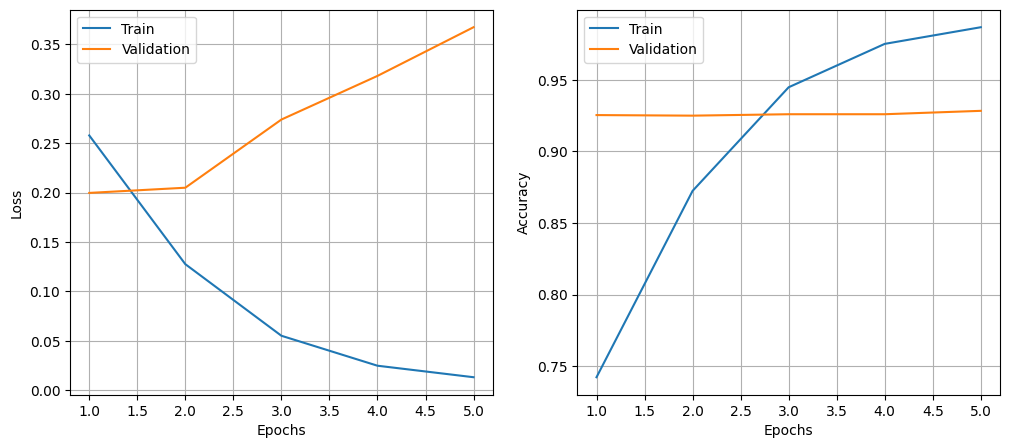

In [20]:
# Plot the train and validation loss and accuracy
epochs_range = range(1, epochs+1)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train')
plt.plot(epochs_range, val_losses, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Train')
plt.plot(epochs_range, val_accuracies, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()



In [21]:
from sklearn.metrics import classification_report

# Evaluate the model on the test dataset
model.eval()
with torch.no_grad():
    test_loss_avg = RunningAverage()
    test_avg = RunningAverage()
    y_true = []
    y_pred = []
    for test_batch_data in test_loader:
        # Load the current batch data on the defined device
        b_test_input_ids = test_batch_data[0].to(device)
        b_test_input_mask = test_batch_data[1].to(device)
        b_test_labels = test_batch_data[2].to(device)

        test_model_output = model(b_test_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_test_input_mask,
                                   labels=b_test_labels)
        test_loss, test_logits = test_model_output['loss'], test_model_output['logits']
        test_loss_avg.update(test_loss.item())
        test_logits = torch.argmax(test_logits, 1)
        # Calculate the test accuracy
        test_batch = torch.sum(test_logits == b_test_labels) / b_test_labels.shape[0]
        test_avg.update(test_batch.item())
        y_true.extend(b_test_labels.cpu().numpy().tolist())
        y_pred.extend(test_logits.cpu().numpy().tolist())

# Print the test accuracy and test loss
print(f'Test loss: {test_loss_avg():.4f}, Test accuracy: {test_avg():.4f}')
print('\n')

# Get the classification report
target_names = [idx_to_sentiment[i] for i in range(len(idx_to_sentiment))]
print(classification_report(y_true, y_pred, target_names=target_names))


Test loss: 0.3397, Test accuracy: 0.9337


              precision    recall  f1-score   support

    positive       0.93      0.94      0.93      2500
    negative       0.94      0.93      0.93      2500

    accuracy                           0.93      5000
   macro avg       0.93      0.93      0.93      5000
weighted avg       0.93      0.93      0.93      5000



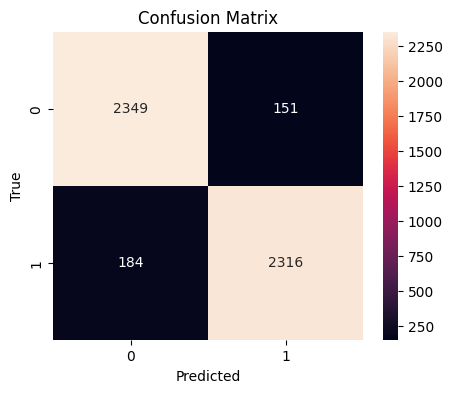

In [22]:
# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## (b) Comparing SSRL (fine-tuned BERT) with Baseline Classification models (Supervised)

### 1) Naive Bayes

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, log_loss

# Convert the PyTorch tensors to a recognized type
train_labels = [int(label) for label in train_split['label']]
test_labels = [int(label) for label in test_split['label']]

vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2))
train_features = vectorizer.fit_transform(train_split['review_preprocessed'])
test_features = vectorizer.transform(test_split['review_preprocessed'])

# Create and train the Naive Bayes classifier
nb_clf = MultinomialNB(alpha=1.8)
nb_clf.fit(train_features, train_labels)


# Evaluate the classifier on the test set
test_preds = nb_clf.predict(test_features)
target_names = [idx_to_sentiment[i] for i in range(len(idx_to_sentiment))]

# Print the test accuracy and test loss
test_acc = accuracy_score(test_labels, test_preds)
test_loss = log_loss(test_labels, nb_clf.predict_proba(test_features))
print(f'Test accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}')
print('\n')

print(classification_report(test_labels, test_preds, target_names=target_names))


Test accuracy: 0.8878, Test loss: 0.4064


              precision    recall  f1-score   support

    positive       0.89      0.89      0.89      2500
    negative       0.89      0.89      0.89      2500

    accuracy                           0.89      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.89      0.89      0.89      5000



In [24]:
print(train_features.shape)
print(test_features.shape)


(40000, 2773517)
(5000, 2773517)


In [25]:
print(f'test samples: {test_split.shape[0]}')

test samples: 5000


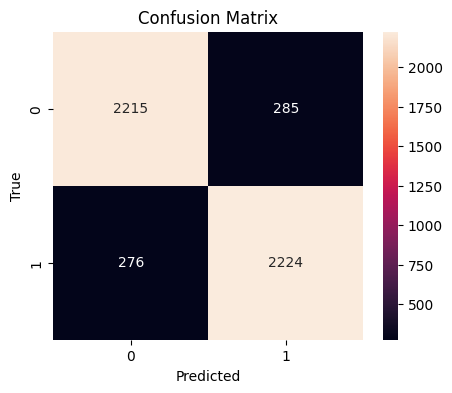

In [26]:

# Create predictions on the test set
test_preds = nb_clf.predict(test_features)

# Create the confusion matrix
cm = confusion_matrix(test_labels, test_preds)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### 2) Linear SVC (Support Vector Classifier)

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, log_loss

# Convert the PyTorch tensors to a recognized type
train_labels = [int(label) for label in train_split['label']]
test_labels = [int(label) for label in test_split['label']]

vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2))
train_features = vectorizer.fit_transform(train_split['review_preprocessed'])
test_features = vectorizer.transform(test_split['review_preprocessed'])

# Create and train the Linear SVC classifier
svc_clf = LinearSVC(C=1.0)
svc_clf.fit(train_features, train_labels)

# Calibrate the classifier for probability estimates
calibrated_svc = CalibratedClassifierCV(svc_clf, cv='prefit')
calibrated_svc.fit(train_features, train_labels)

# Evaluate the classifier on the test set
test_preds = calibrated_svc.predict(test_features)
target_names = [idx_to_sentiment[i] for i in range(len(idx_to_sentiment))]

# Print the test accuracy and test loss
test_acc = accuracy_score(test_labels, test_preds)
test_loss = log_loss(test_labels, calibrated_svc.predict_proba(test_features))
print(f'Test accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}')
print('\n')

print(classification_report(test_labels, test_preds, target_names=target_names))


Test accuracy: 0.9086, Test loss: 0.3382


              precision    recall  f1-score   support

    positive       0.90      0.92      0.91      2500
    negative       0.92      0.90      0.91      2500

    accuracy                           0.91      5000
   macro avg       0.91      0.91      0.91      5000
weighted avg       0.91      0.91      0.91      5000



In [41]:
print(train_features.shape)
print(test_features.shape)


(40000, 2773517)
(5000, 2773517)


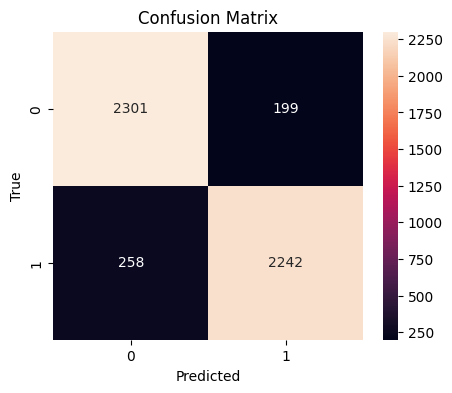

In [42]:
# Create predictions on the test set
test_preds = calibrated_svc.predict(test_features)

# Create the confusion matrix
cm = confusion_matrix(test_labels, test_preds)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### 3) LSTM  (Deep learning model)

In [41]:
# import libraries

# data manipulation
import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# pytorch
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader

# sklearn
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# utils
import os
from tqdm import tqdm
tqdm.pandas()
from collections import Counter

In [15]:
# copy to another dataframe for manipulation
data = imdb_df

In [16]:
# As we can see, we have sentiment label in text format. In this case, we need to transform these labels into number.
#We will define positive as 1 and negative as 0.

def transform_label(label):
    return 1 if label == 'positive' else 0

data['label'] = data['sentiment'].progress_apply(transform_label)
data.head()

100%|█████████████████████████████████████████████████████████████████████████| 50000/50000 [00:00<00:00, 660680.54it/s]


,review,sentiment,label,review_preprocessed,input_ids,attention_mask
0,One of the other reviewers has mentioned that ...,positive,1,one of the other reviewers has mentioned that ...,"[tensor(101), tensor(2028), tensor(1997), tens...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
1,A wonderful little production. <br /><br />The...,positive,1,a wonderful little production the filming tech...,"[tensor(101), tensor(1037), tensor(6919), tens...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
2,I thought this was a wonderful way to spend ti...,positive,1,i thought this was a wonderful way to spend ti...,"[tensor(101), tensor(1045), tensor(2245), tens...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
3,Basically there's a family where a little boy ...,negative,0,basically there's a family where a little boy ...,"[tensor(101), tensor(10468), tensor(2045), ten...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1,"petter mattei's ""love in the time of money"" is...","[tensor(101), tensor(9004), tensor(3334), tens...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."


In [17]:
# check if we have an imbalance case by looking at total dataset of each positive and negative classes

data.sentiment.value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

In [18]:
# Now, we want to see token distribution in our dataset. We want to see token distribution for each positive and 
# negative labels. We will split sentences by whitespaces and count total tokens by len() function.

data['token_length'] = data.review.progress_apply(lambda x: len(x.split()))

100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [00:02<00:00, 19412.76it/s]


In [19]:
data_pos = data[data['label'] == 1]
data_pos['token_length'].describe()

count    25000.000000
mean       232.849320
std        177.497046
min         10.000000
25%        125.000000
50%        172.000000
75%        284.000000
max       2470.000000
Name: token_length, dtype: float64

For positive reviews, we have maximum token 2470 and minimum token 10. While the average token is 232.85

In [20]:


data_neg = data[data['label'] == 0]
data_neg['token_length'].describe()



count    25000.000000
mean       229.464560
std        164.947795
min          4.000000
25%        128.000000
50%        174.000000
75%        278.000000
max       1522.000000
Name: token_length, dtype: float64



And for negative reviews, we have maximum and minimum token respectively 1522 and 4. While the average token is 229.46


<Figure size 500x800 with 0 Axes>

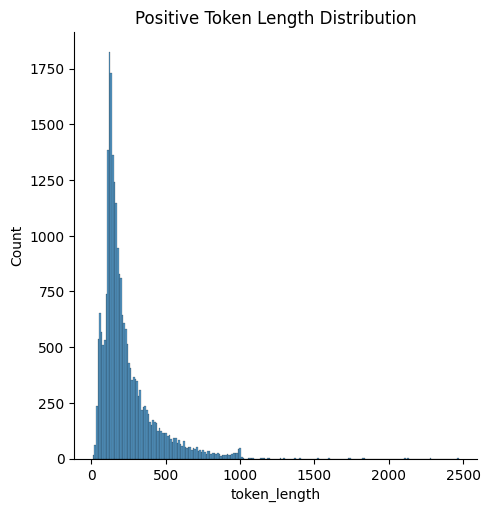

In [21]:
plt.figure(figsize=(5, 8))
sns.displot(data_pos, x='token_length')
plt.title('Positive Token Length Distribution')
plt.show()

<Figure size 500x800 with 0 Axes>

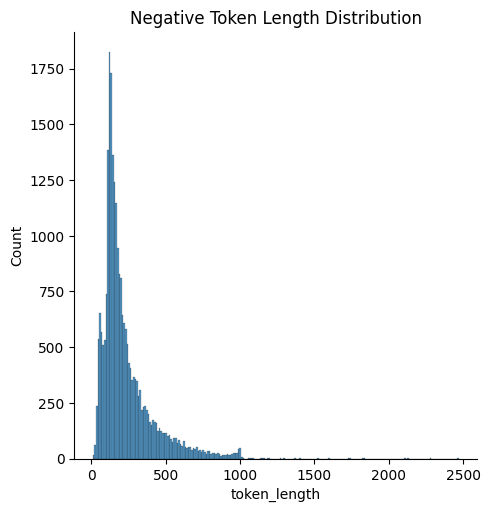

In [22]:
plt.figure(figsize=(5, 8))
sns.displot(data_pos, x='token_length')
plt.title('Negative Token Length Distribution')
plt.show()

In [28]:
# see most minimum length token
print('Positive')
print(data_pos[data_pos['token_length'] == data_pos['token_length'].min()]['review'].item())  # 10
print()
print('Negative')
print(data_neg[data_neg['token_length'] == data_neg['token_length'].min()]['review'].item())  # 4

Positive
Brilliant and moving performances by Tom Courtenay and Peter Finch.

Negative
Primary plot!Primary direction!Poor interpretation.


In [29]:
# keep only processed and label columns
data[['review_preprocessed', 'label']].to_csv('./imdb_processed.csv', index=False, header=True)
data.head()

,review_preprocessed,label
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production the filming tech...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically there's a family where a little boy ...,0
4,"petter mattei's ""love in the time of money"" is...",1


In [30]:
# read processed data
data = pd.read_csv('./imdb_processed.csv')

for row in data[:2].iterrows():
    print(row[1]['review_preprocessed'])
    print(f'Label: {row[1]["label"]}')    
    print('\n')

one of the other reviewers has mentioned that after watching just 1 oz episode you'll be hooked they are right as this is exactly what happened with methe first thing that struck me about oz was its brutality and unflinching scenes of violence which set in right from the word go trust me this is not a show for the faint hearted or timid this show pulls no punches with regards to drugs sex or violence its is hardcore in the classic use of the wordit is called oz as that is the nickname given to the oswald maximum security state penitentary it focuses mainly on emerald city an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda em city is home to manyaryans muslims gangstas latinos christians italians irish and moreso scuffles death stares dodgy dealings and shady agreements are never far awayi would say the main appeal of the show is due to the fact that it goes where other shows wouldn't dare forget pretty pictu

In [31]:

# get all processed reviews
reviews = data.review_preprocessed.values
# merge into single variable, separated by whitespaces
words = ' '.join(reviews)
# obtain list of words
words = words.split()

# check our list
words[:10]

['one',
 'of',
 'the',
 'other',
 'reviewers',
 'has',
 'mentioned',
 'that',
 'after',
 'watching']

In [32]:
# build vocabulary
#convert words in the dataset to their respective integer representations for further processing in the model.

counter = Counter(words)
vocab = sorted(counter, key=counter.get, reverse=True)
int2word = dict(enumerate(vocab, 1))
int2word[0] = '<PAD>'
word2int = {word: id for id, word in int2word.items()}
print(len(word2int))   # number of unique words in the vocabulary including the <PAD> token.

262424


In [47]:
# example: last word

last_word_key = len(word2int) - 1
print(int2word[last_word_key])


yosemitei


In [33]:
# encode words
# encode our reviews by converting each token into corresponding index in vocabulary that we just created.
reviews_enc = [[word2int[word] for word in review.split()] for review in tqdm(reviews)]

# print first-5 words of first 5 reviews
for i in range(5):
    print(reviews_enc[i][:5])

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [00:08<00:00, 5689.27it/s]

[27, 4, 1, 77, 2002]
[3, 380, 113, 354, 1]
[10, 190, 9, 12, 3]
[673, 225, 3, 239, 112]
[99050, 36720, 6048, 7, 1]


In [34]:
# padding sequences

# As we know, the length review sometimes is different. So, first we need to define our maximum sequence length. 
#Then, for each reviews that shorter than our predefined sequence length we will add padding token. 
#Otherwise, we will trim the reviews.

def pad_features(reviews, pad_id, seq_length=128):  # default 128
    # features = np.zeros((len(reviews), seq_length), dtype=int)
    features = np.full((len(reviews), seq_length), pad_id, dtype=int)

    for i, row in enumerate(reviews):
        # if seq_length < len(row) then review will be trimmed
        features[i, :len(row)] = np.array(row)[:seq_length]

    return features

seq_length = 256
features = pad_features(reviews_enc, pad_id=word2int['<PAD>'], seq_length=seq_length)

assert len(features) == len(reviews_enc)
assert len(features[0]) == seq_length

features[:10, :10]

array([[   27,     4,     1,    77,  2002,    41,  1052,    11,    99,
          143],
       [    3,   380,   113,   354,     1,  1333,  2937,     6,    50,
        18371],
       [   10,   190,     9,    12,     3,   380,    96,     5,  1097,
           59],
       [  673,   225,     3,   239,   112,     3,   113,   454,  3737,
         1176],
       [99050, 36720,  6048,     7,     1,    59,     4, 15206,     6,
            3],
       [  235,    56,  3671,   493,    16,     3,    66,     4, 49736,
         4209],
       [   10,   247,    53,    35,     5,    63,     3,  9390,     4,
            3],
       [    9,   118,    12,    31,   481,  1419,  4028,   313,     7,
            1],
       [ 8268,    30,     1,  1115,   763,    40,     9,    18,    19,
          134],
       [   43,    21,    35,   209,  7413,  8956,  2174,    21,    75,
           35]])

In [35]:
# get labels as numpy
labels = imdb_df.label.to_numpy()
labels

array([1, 1, 1, ..., 0, 0, 0])

In [36]:

# split the data into train, validation, and test sets
train_x, test_val_x, train_y, test_val_y = train_test_split(features, labels, test_size=0.2, random_state=0, stratify=labels)
val_x, test_x, val_y, test_y = train_test_split(test_val_x, test_val_y, test_size=0.5, random_state=0, stratify=test_val_y)

# print out the shape
print('Feature Shapes:')
print('===============')
print('Train set: {}'.format(train_x.shape))
print('Validation set: {}'.format(val_x.shape))
print('Test set: {}'.format(test_x.shape))


Feature Shapes:
Train set: (40000, 256)
Validation set: (5000, 256)
Test set: (5000, 256)


In [37]:
print(len(train_y[train_y == 0]), len(train_y[train_y == 1]))  # length of train labels {0, 1}
print(len(val_y[val_y == 0]), len(val_y[val_y == 1]))       # length of validation labels {0, 1}
print(len(test_y[test_y == 0]), len(test_y[test_y == 1]))     # length of test labels {0, 1}

20000 20000
2500 2500
2500 2500


In [38]:

import torch.nn as nn


# LSTM model architecture

class LSTMSentimentModel(nn.Module):
    def __init__(self, vocab_size, output_size, hidden_size=128, embedding_size=256, n_layers=2, dropout=0.2):
        super(LSTMSentimentModel, self).__init__()

        # embedding layer is useful to map input into vector representation
        self.embedding = nn.Embedding(vocab_size, embedding_size)

        # LSTM layer preserved by PyTorch library
        self.lstm = nn.LSTM(embedding_size, hidden_size, n_layers, dropout=dropout, batch_first=True)

        # dropout layer
        self.dropout = nn.Dropout(0.3)

        # Linear layer for output
        self.fc = nn.Linear(hidden_size, output_size)

        # Sigmoid layer cz we will have binary classification
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        
        # convert feature to long
        x = x.long()

        # map input to vector
        x = self.embedding(x)

        # pass forward to lstm
        o, _ =  self.lstm(x)

        # get last sequence output
        o = o[:, -1, :]

        # apply dropout and fully connected layer
        o = self.dropout(o)
        o = self.fc(o)

        # sigmoid
        o = self.sigmoid(o)

        return o

In [39]:
# define batch size
batch_size = 64

# create tensor datasets
trainset = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
validset = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
testset = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

# create dataloaders
trainloader = DataLoader(trainset, shuffle=True, batch_size=batch_size)
valloader = DataLoader(validset, shuffle=True, batch_size=batch_size)
testloader = DataLoader(testset, shuffle=True, batch_size=batch_size)

In [40]:
# model hyperparamters
vocab_size = len(word2int)
output_size = 1
embedding_size = 256
hidden_size = 512
n_layers = 2
dropout=0.25  

# model initialization
model = LSTMSentimentModel(vocab_size, output_size, hidden_size, embedding_size, n_layers, dropout)
print(model)

LSTMSentimentModel(
  (embedding): Embedding(262424, 256)
  (lstm): LSTM(256, 512, num_layers=2, batch_first=True, dropout=0.25)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [32]:
# training config

lr = 0.001
criterion = nn.BCELoss()  # we use BCELoss cz we have binary classification problem
optim = Adam(model.parameters(), lr=lr)
grad_clip = 5
epochs = 15
print_every = 1
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'epochs': epochs
}
es_limit = 5

In [96]:
# train loop

device = torch.device('cuda:7')
model = model.to(device)

epochloop = tqdm(range(epochs), position=0, desc='Training', leave=True)

# early stop trigger
es_trigger = 0
val_loss_min = torch.inf

for e in epochloop:

    ## training mode ##

    model.train()

    train_loss = 0
    train_acc = 0

    for id, (feature, target) in enumerate(trainloader):
        # add epoch meta info
        epochloop.set_postfix_str(f'Training batch {id}/{len(trainloader)}')

        # move to device
        feature, target = feature.to(device), target.to(device)

        # reset optimizer
        optim.zero_grad()

        # forward pass
        out = model(feature)

        # acc
        predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
        equals = predicted == target
        acc = torch.mean(equals.type(torch.FloatTensor))
        train_acc += acc.item()

        # loss
        loss = criterion(out.squeeze(), target.float())
        train_loss += loss.item()
        loss.backward()

        # clip grad
        nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

        # update optimizer
        optim.step()

        # free some memory
        del feature, target, predicted

    history['train_loss'].append(train_loss / len(trainloader))
    history['train_acc'].append(train_acc / len(trainloader))

  
    ## validation mode ##
    
    model.eval()

    val_loss = 0
    val_acc = 0

    with torch.no_grad():
        for id, (feature, target) in enumerate(valloader):
            # add epoch meta info
            epochloop.set_postfix_str(f'Validation batch {id}/{len(valloader)}')
            
            # move to device
            feature, target = feature.to(device), target.to(device)

            # forward pass
            out = model(feature)

            # acc
            predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
            equals = predicted == target
            acc = torch.mean(equals.type(torch.FloatTensor))
            val_acc += acc.item()

            # loss
            loss = criterion(out.squeeze(), target.float())
            val_loss += loss.item()

            # free some memory
            del feature, target, predicted

        history['val_loss'].append(val_loss / len(valloader))
        history['val_acc'].append(val_acc / len(valloader))

    # reset model mode
    model.train()

    # add epoch meta info
    epochloop.set_postfix_str(f'Val Loss: {val_loss / len(valloader):.3f} | Val Acc: {val_acc / len(valloader):.3f}')

    # print epoch
    if (e+1) % print_every == 0:
        epochloop.write(f'Epoch {e+1}/{epochs} | Train Loss: {train_loss / len(trainloader):.3f} Train Acc: {train_acc / len(trainloader):.3f} | Val Loss: {val_loss / len(valloader):.3f} Val Acc: {val_acc / len(valloader):.3f}')
        epochloop.update()

    # save model if validation loss decrease
    if val_loss / len(valloader) <= val_loss_min:
        torch.save(model.state_dict(), './sentiment_lstm.pt')
        val_loss_min = val_loss / len(valloader)
        es_trigger = 0
    else:
        epochloop.write(f'[WARNING] Validation loss did not improved ({val_loss_min:.3f} --> {val_loss / len(valloader):.3f})')
        es_trigger += 1

    # force early stop
    if es_trigger >= es_limit:
        epochloop.write(f'Early stopped at Epoch-{e+1}')
        # update epochs history
        history['epochs'] = e+1
        break

Training:   7%|██▋                                     | 1/15 [00:20<04:51, 20.84s/it, Val Loss: 0.693 | Val Acc: 0.504]

Epoch 1/15 | Train Loss: 0.694 Train Acc: 0.506 | Val Loss: 0.693 Val Acc: 0.504


Training:  20%|██████████▍                                         | 3/15 [00:45<03:03, 15.30s/it, Training batch 5/625]

Epoch 2/15 | Train Loss: 0.694 Train Acc: 0.500 | Val Loss: 0.693 Val Acc: 0.499
[WARNING] Validation loss did not improved (0.693 --> 0.693)


Training:  27%|██████████▋                             | 4/15 [01:06<03:12, 17.53s/it, Val Loss: 0.692 | Val Acc: 0.521]

Epoch 3/15 | Train Loss: 0.693 Train Acc: 0.507 | Val Loss: 0.692 Val Acc: 0.521


Training:  40%|████████████████████▊                               | 6/15 [01:32<02:20, 15.65s/it, Training batch 4/625]

Epoch 4/15 | Train Loss: 0.688 Train Acc: 0.523 | Val Loss: 0.694 Val Acc: 0.510
[WARNING] Validation loss did not improved (0.692 --> 0.694)


Training:  47%|████████████████████████▎                           | 7/15 [01:53<02:18, 17.37s/it, Training batch 5/625]

Epoch 5/15 | Train Loss: 0.677 Train Acc: 0.544 | Val Loss: 0.698 Val Acc: 0.523
[WARNING] Validation loss did not improved (0.692 --> 0.698)


Training:  53%|█████████████████████▎                  | 8/15 [02:13<02:09, 18.51s/it, Val Loss: 0.387 | Val Acc: 0.838]

Epoch 6/15 | Train Loss: 0.500 Train Acc: 0.749 | Val Loss: 0.387 Val Acc: 0.838


Training:  67%|██████████████████████████             | 10/15 [02:39<01:21, 16.22s/it, Val Loss: 0.356 | Val Acc: 0.855]

Epoch 7/15 | Train Loss: 0.296 Train Acc: 0.881 | Val Loss: 0.356 Val Acc: 0.855


Training:  73%|█████████████████████████████████████▍             | 11/15 [03:04<01:15, 18.93s/it, Training batch 4/625]

Epoch 8/15 | Train Loss: 0.171 Train Acc: 0.940 | Val Loss: 0.410 Val Acc: 0.858
[WARNING] Validation loss did not improved (0.356 --> 0.410)


Training:  80%|████████████████████████████████████████▊          | 12/15 [03:25<00:58, 19.64s/it, Training batch 5/625]

Epoch 9/15 | Train Loss: 0.105 Train Acc: 0.966 | Val Loss: 0.426 Val Acc: 0.857
[WARNING] Validation loss did not improved (0.356 --> 0.426)


Training:  93%|███████████████████████████████████████████████▌   | 14/15 [03:46<00:20, 20.01s/it, Training batch 4/625]

Epoch 10/15 | Train Loss: 0.059 Train Acc: 0.983 | Val Loss: 0.463 Val Acc: 0.860
[WARNING] Validation loss did not improved (0.356 --> 0.463)


Training: 100%|███████████████████████████████████████████████████| 15/15 [04:07<00:00, 15.64s/it, Training batch 4/625]

Epoch 11/15 | Train Loss: 0.039 Train Acc: 0.989 | Val Loss: 0.605 Val Acc: 0.863
[WARNING] Validation loss did not improved (0.356 --> 0.605)


Training:  73%|████████████████████████████▌          | 11/15 [04:28<01:37, 24.42s/it, Val Loss: 0.592 | Val Acc: 0.852]

Epoch 12/15 | Train Loss: 0.031 Train Acc: 0.992 | Val Loss: 0.592 Val Acc: 0.852
[WARNING] Validation loss did not improved (0.356 --> 0.592)
Early stopped at Epoch-12


In [97]:
# test loop
model.eval()

# metrics
test_loss = 0
test_acc = 0

all_target = []
all_predicted = []

testloop = tqdm(testloader, leave=True, desc='Inference')
with torch.no_grad():
    for feature, target in testloop:
        feature, target = feature.to(device), target.to(device)

        out = model(feature)
        
        predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
        equals = predicted == target
        acc = torch.mean(equals.type(torch.FloatTensor))
        test_acc += acc.item()

        loss = criterion(out.squeeze(), target.float())
        test_loss += loss.item()

        all_target.extend(target.cpu().numpy())
        all_predicted.extend(predicted.cpu().numpy())

    print(f'Test Accuracy: {test_acc/len(testloader):.4f}, Test Loss: {test_loss/len(testloader):.4f}')

Inference: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 82.14it/s]

Test Accuracy: 0.8665, Test Loss: 0.5448


In [98]:
print(classification_report(all_predicted, all_target))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86      2286
           1       0.91      0.84      0.87      2714

    accuracy                           0.87      5000
   macro avg       0.87      0.87      0.87      5000
weighted avg       0.87      0.87      0.87      5000



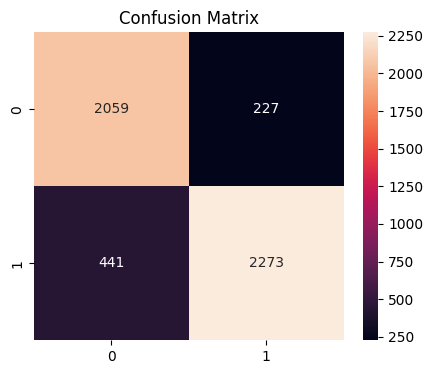

In [99]:
cm = confusion_matrix(all_predicted, all_target)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.show()

## (c) Comparing Results of 4 models through graphs
### Self-supervised Representation Learning vs Supervised Learning Models

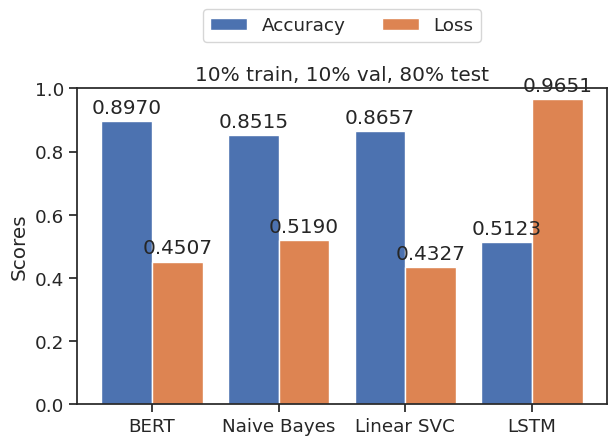

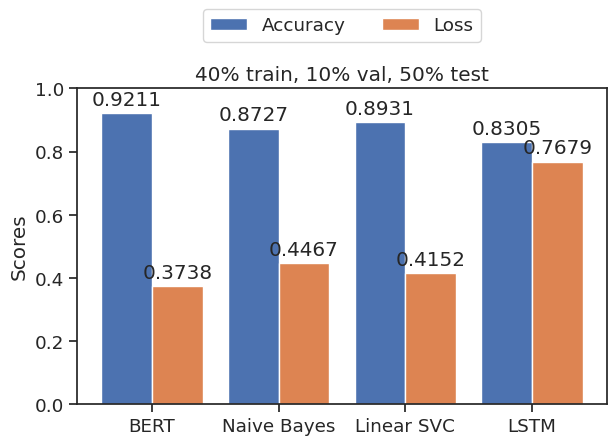

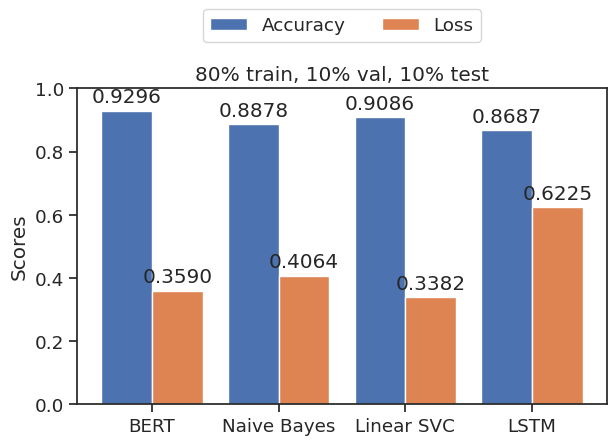

In [93]:
import matplotlib.pyplot as plt
import numpy as np

# data for the first split
data1 = {
    'BERT': {'Test accuracy': 0.8970, 'Test loss': 0.4507},
    'Naive Bayes': {'Test accuracy': 0.8515, 'Test loss': 0.5190},
    'Linear SVC': {'Test accuracy': 0.8657, 'Test loss': 0.4327},
    'LSTM': {'Test accuracy': 0.5123, 'Test loss': 0.9651}
}

# data for the second split
data2 = {
    'BERT': {'Test accuracy': 0.9211, 'Test loss': 0.3738},
    'Naive Bayes': {'Test accuracy': 0.8727, 'Test loss': 0.4467},
    'Linear SVC': {'Test accuracy': 0.8931, 'Test loss': 0.4152},
    'LSTM': {'Test accuracy': 0.8305, 'Test loss': 0.7679}
}

# data for the third split
data3 = {
    'BERT': {'Test accuracy': 0.9296, 'Test loss': 0.3590},
    'Naive Bayes': {'Test accuracy': 0.8878, 'Test loss': 0.4064},
    'Linear SVC': {'Test accuracy': 0.9086, 'Test loss': 0.3382},
    'LSTM': {'Test accuracy': 0.8687, 'Test loss': 0.6225}
}

# function to plot a bar graph given the data and title
def plot_bar_graph(data, title):
    models = list(data.keys())
    accuracy = [data[model]['Test accuracy'] for model in models]
    loss = [data[model]['Test loss'] for model in models]
    x = np.arange(len(models))

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - 0.2, accuracy, 0.4, label='Accuracy')
    rects2 = ax.bar(x + 0.2, loss, 0.4, label='Loss')

    for rect in rects1:
        height = rect.get_height()
        ax.annotate('{:.4f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
    for rect in rects2:
        height = rect.get_height()
        ax.annotate('{:.4f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
                    
    ax.set_ylabel('Scores')
    ax.set_xticks(x)
    ax.set_xticklabels(models)
    ax.legend(loc='center', bbox_to_anchor=(0.5, 1.2), ncol=2)
    ax.set_ylim([0, 1])
    ax.set_title(title)
    fig.tight_layout()

#plot the three bar graphs
plot_bar_graph(data1, '10% train, 10% val, 80% test')
plot_bar_graph(data2, '40% train, 10% val, 50% test')
plot_bar_graph(data3, '80% train, 10% val, 10% test')

#display the plots
plt.show()


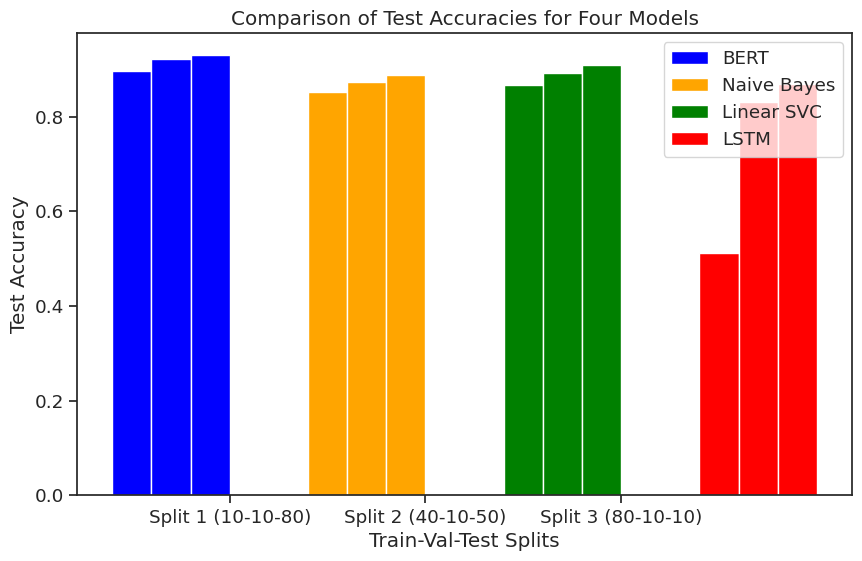

In [102]:


# Test accuracies for each model and split
split1 = ['10-10-80', 0.8970, 0.8515, 0.8657, 0.5123]
split2 = ['40-10-50', 0.9211, 0.8727, 0.8931, 0.8305]
split3 = ['80-10-10', 0.9296, 0.8878, 0.9086, 0.8687]

# Set up the data and labels for the bar graph
splits = [split1, split2, split3]
models = ['BERT', 'Naive Bayes', 'Linear SVC', 'LSTM']
colors = ['blue', 'orange', 'green', 'red']

# Create the bar graph
fig, ax = plt.subplots(figsize=(10, 6))
width = 0.2
for i in range(len(splits)):
    x = [j+(i*width) for j in range(len(models))]
    for j in range(len(models)):
        ax.bar(x[j], splits[i][j+1], width, color=colors[j])

# Add labels and legend
ax.set_ylabel('Test Accuracy')
ax.set_xlabel('Train-Val-Test Splits')
ax.set_title('Comparison of Test Accuracies for Four Models')

# Define custom x-axis labels
custom_xticklabels = ['Split 1 (10-10-80)', 'Split 2 (40-10-50)', 'Split 3 (80-10-10)']
ax.set_xticks([0.5, 1.5, 2.5])
ax.set_xticklabels(custom_xticklabels)

ax.legend(models)

plt.show()
